In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
from io import open
import glob
import unicodedata
import string
import numpy as np
import time
import math

In [2]:
data_path = './data/text_samples/*.txt'

class LanguageDetect():
    def __init__(self, files_path='./data/text_samples', limit_size=None):
        # scan language files
        lang_files = glob.glob(data_path)
        
        self.alphabet = string.ascii_lowercase
        self.wordlist = []
        self.labels = []
        self.classes = []
        self.padding = 0

        idx = 0
        for file in lang_files:
            language = os.path.splitext(os.path.basename(file))[0]
            self.classes.append(language)
            words = self._transform_vocab(file, limit_size)
            self.wordlist += words
            self.labels += [idx for i in range(len(words))]
            idx += 1
        
        self.padding = len(max(self.wordlist, key=len)) # size of the largest string
           
    def _unicodeToAscii(self, s):
        all_letters = string.ascii_letters
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in all_letters)

    def _transform_vocab(self, vocab, limit_size):
        wordset = (open(vocab).read()).lower() # open file and convert letters to lowercase
        wordset = ''.join(i for i in wordset if (i.isalpha() | i.isspace())).split() # remove all non alpha and single characters thus split into a list
        wordset = [word for word in wordset if len(word) > 1] # remove single characters and spaces
        wordset = [self._unicodeToAscii(word) for word in wordset] # convert to ASCII
        wordset = list(set(wordset)) # list of unique elements
        if limit_size is not None:
            wordset = wordset[:limit_size]
        return wordset


    def _word2tensor(self, word, padding=True):
        if padding:
            num_charac = self.padding # pad to the fill the size
        else:
            num_charac = len(word)
        len_word = len(word)
        wtensor = torch.zeros(num_charac, 1, 1, dtype=torch.long)
        for iletter in range(len_word):
            wtensor[iletter][0][0] = self.alphabet.find(word[iletter])
        return wtensor

    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        word = self.wordlist[idx]
        label = self.labels[idx]
        
        # convert a word to a tensor (len word x 1 x alphabet)
        word = self._word2tensor(word, padding=False)
       
        return word, label
        
        

In [3]:
dataset = LanguageDetect(data_path, limit_size=200)
alphabet = dataset.alphabet

classes = dataset.classes
print('dataset size:', len(dataset))
print('classes:', classes)

dataset size: 800
classes: ['german', 'spanish', 'french', 'english']


In [4]:
vocab_size = len(alphabet)
print('vocab_size:', vocab_size)

vocab_size: 26


In [5]:
def tensor2word(tensor):
    word = ''
    for i in range(tensor.size(0)):
        word += alphabet[tensor[i][0][0]]
                word += alphabet[j]
    return word
        
    
# dataset dim = |idx (input,label) 
# first input
print('first input:', dataset[0][0].size())
# first label
print('label:', dataset[0][1])
print()

# sample example
sample_idx = np.random.randint(1, len(dataset))

print('Random sample:')
print('language=', classes[dataset[sample_idx][1]])
print('word=', tensor2word(dataset[sample_idx][0]))

first input: torch.Size([5, 1, 1])
label: 0

Random sample:
language= german
word= tropenhaus


In [6]:
# split dataset
train_size = len(dataset)

# creating dataloaders
batch_size = 1

# create training data loader
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

### The model will be based on the following chart
![LSTM model](./images/lan_class_lstm.png)

In [8]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim) 
        self.lstm = nn.LSTM(embedding_dim, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, last_hidden):
        embedded = self.embeddings(input.view(-1)).view(1, 1, -1)
        output, hidden = self.lstm(embedded, last_hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return hidden, output
        
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), 
                torch.zeros(1, 1, self.hidden_size, device=device)) 

In [9]:
# hidden NN size
hidden_size = 128
embedded_dim = 128

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using gpu:", use_cuda)

Using gpu: True


In [11]:
#rnn = RNN(len(alphabet), hidden_size, len(classes)).to(device)
rnn = LSTM(vocab_size, embedded_dim, hidden_size, len(classes)).to(device)

In [12]:
criterion = nn.NLLLoss()
learning_rate = 0.0001

PATH_state_dict = './lang_class.pth' # file to be stored the best weights of the trained model

In [13]:
def train(model, criterion, learning_rate=0.0001, epochs=1000, plots_per_epoch=100):
    
    cost = []
    start_time = time.time()
    
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        running_corrects = 0
        model.train()
        
        for inputs, labels in train_loader:
            inputs = inputs[0].to(device)
            labels = labels.to(device)
            
            hidden = model.init_hidden()
            model.zero_grad()

            for i in range(inputs.size(0)): # go through each letter
                hidden, output = model(inputs[i], hidden)
                
            loss = criterion(output, labels)
            loss.backward()
            
            # Add parameters' gradients to their values, multiplied by learning rate
            for par in model.parameters():
                par.data.add_(-learning_rate, par.grad.data)

            _, guess = output.topk(1) # return the 1 largest element from output tensor
            guess = guess[0].item()
            if guess == int(labels):
                running_corrects += 1
            running_loss += loss.item()
            
        cost.append(running_loss)
        epoch_acc = running_corrects / train_size
        
        if epoch % plots_per_epoch == 0:
            print('Epoch [{}] -> Loss: {:.4f}  Acc: {:.4f}'.format(
                epoch, running_loss/train_size, epoch_acc))

    
    time_elapsed = time.time() - start_time
    print()
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    torch.save(model.state_dict(), PATH_state_dict)
    
    return model, cost

In [14]:
_, cost = train(rnn, criterion, learning_rate, epochs=2000)

Epoch [100] -> Loss: 1.0784  Acc: 0.5513
Epoch [200] -> Loss: 0.9552  Acc: 0.6075
Epoch [300] -> Loss: 0.8599  Acc: 0.6650
Epoch [400] -> Loss: 0.7866  Acc: 0.6863
Epoch [500] -> Loss: 0.7287  Acc: 0.7175
Epoch [600] -> Loss: 0.6681  Acc: 0.7512
Epoch [700] -> Loss: 0.6017  Acc: 0.7750
Epoch [800] -> Loss: 0.5296  Acc: 0.8175
Epoch [900] -> Loss: 0.4597  Acc: 0.8425
Epoch [1000] -> Loss: 0.3940  Acc: 0.8712
Epoch [1100] -> Loss: 0.3323  Acc: 0.8938
Epoch [1200] -> Loss: 0.2760  Acc: 0.9125
Epoch [1300] -> Loss: 0.2277  Acc: 0.9413
Epoch [1400] -> Loss: 0.1864  Acc: 0.9525
Epoch [1500] -> Loss: 0.1528  Acc: 0.9625
Epoch [1600] -> Loss: 0.1271  Acc: 0.9700
Epoch [1700] -> Loss: 0.1053  Acc: 0.9775
Epoch [1800] -> Loss: 0.0900  Acc: 0.9800
Epoch [1900] -> Loss: 0.0773  Acc: 0.9788
Epoch [2000] -> Loss: 0.0682  Acc: 0.9788

Training completed in 120m 11s


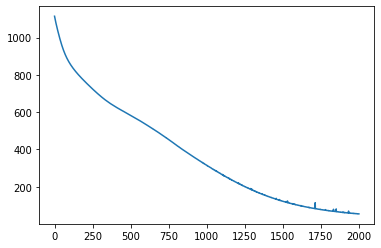

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(cost)

In [19]:
n_confusion = int(0.5 * train_size) # half of the train dataset to be evaluated

def confusion_matrix(model):
    confusion = torch.zeros(len(classes), len(classes))
    model.eval()
    for i in range(n_confusion):
        for inputs, label in train_loader:
            inputs = inputs.to(device)
            label = label.to(device)
            hidden = model.init_hidden()

            word = inputs[0]
            for i in range(word.size()[0]): # go through each letter
                if torch.sum(word[i]) > 0: # avoid paddding
                    hidden, output = model(word[i], hidden)
                else: break

            _, guess = output.topk(1) # return the 1 largest element
            guess = guess[0].item()
            
            confusion[int(label)][guess] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + classes, rotation=90)
    ax.set_yticklabels([''] + classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

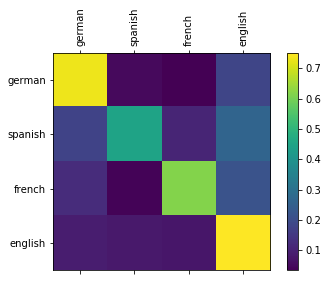

In [20]:
confusion_matrix(rnn)